# Imports

In [77]:
#pip install import_ipynb

In [1]:
import pandas as pd
import json
import import_ipynb
import matplotlib.pyplot as plt #visualizations
from datetime import datetime

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import seaborn as sns #visualizations

Modified invoice generator

In [3]:
import json
import random
import re
from datetime import datetime, timedelta
import numpy as np
from faker import Faker
import uuid
from collections import defaultdict

# Set up the Faker generator with a fixed seed for reproducibility
fake = Faker(['en_US'])

with open('synthetic_data_configs.json','r') as f:
    synthetic_data_configs = json.load(f)

def merchant_name_generator(merchant_types,company_suffixes):
            # Company Name Generator

    name_prefix = random.choice([
        fake.last_name(),
        fake.last_name() + " & " + fake.last_name(),
        fake.last_name() + "-" + fake.last_name(),
        fake.word().capitalize(),
        fake.word().capitalize() + fake.word().capitalize(),
    ])
    
    merchant_type = random.choice(merchant_types)
    suffix = random.choice(company_suffixes)
    
    merchant_name = [name_prefix]
    if random.random() >= 0.7:
        merchant_name.append(merchant_type)
    if random.random() >= 0.5:
        merchant_name.append(suffix)
    return (' '.join(merchant_name), merchant_type)

def generate_merchant_data(num_merchants=20):
    """
    Generate a diverse set of realistic merchant data
    
    Parameters:
    num_merchants (int): Number of merchants to generate
    
    Returns:
    list: List of merchant dictionaries
    """
    merchant_types = synthetic_data_configs["merchant_types"]
    company_suffixes = synthetic_data_configs["company_suffixes"]
    
    merchants = [
        {
            "name": "Curtis Instruments, Inc.",
            "address": "200 Kisco Avenue Mount Kisco NY 10549 USA",
            "city": "Mount Kisco",  # Added this
            "state": "NY",          # Added this
            "country": "US",
            "type": "Electronics"
        }
    ]
    
    # Create a set to track unique merchant names
    existing_names = {merchants[0]["name"]}
    
    # Generate additional merchants
    for _ in range(num_merchants - 1):
        country_code = 'US'
        
        fake.seed_instance(random.randint(1, 9999))
            
        # US address
        street = fake.street_address()
        city = fake.city()
        state = fake.state_abbr()
        zip_code = fake.zipcode()
        address = f"{street} {city} {state} {zip_code} USA"
        
        # Merchant Name Generator
        while True:
            merchant_name,merchant_type = merchant_name_generator(merchant_types, company_suffixes)

            # Check for uniqueness
            if merchant_name not in existing_names:
                existing_names.add(merchant_name)
                break
        
        merchants.append({
            "name": merchant_name,
            "address": address,
            "city": city,
            "state": state,
            "country": country_code,
            "type": merchant_type
        })
    
    return merchants

def generate_product_catalog():
    """
    Generate a realistic product catalog with categories and products
    
    Returns:
    dict: Dictionary mapping categories to lists of products
    """
    categories = synthetic_data_configs["categories"]
    
    # Generate product catalog
    catalog = {}
    
    for category, product_types in categories.items():
        catalog[category] = []
        
        # Generate 15-30 products per category
        for _ in range(random.randint(15, 30)):
            product_type = random.choice(product_types)
            
            # Generate model number
            model_prefix = ''.join(random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ') for _ in range(random.randint(1, 3)))
            model_suffix = ''.join(random.choice('0123456789') for _ in range(random.randint(3, 5)))
            model = f"{model_prefix}-{model_suffix}"
            
            # Generate specification
            specs = [
                "Standard", "Premium", "Industrial", "Commercial", "Professional",
                "Heavy Duty", "Lightweight", "Compact", "Extended", "High Performance",
                "Economy", "Deluxe", "Ultimate", "Basic", "Advanced"
            ]
            spec = random.choice(specs)
            
            # Generate description
            description = f"{model} {spec} {product_type}"
            
            # Generate price based on category and specification
            base_price = {
                "Electronics": random.uniform(50, 500),
                "Industrial": random.uniform(100, 1000),
                "Office Supplies": random.uniform(10, 200),
                "Manufacturing": random.uniform(50, 800),
                "Automotive": random.uniform(30, 600),
                "Medical": random.uniform(100, 2000),
                "Construction": random.uniform(20, 500),
                "Technology": random.uniform(100, 3000),
                "Laboratory": random.uniform(50, 1500),
                "Engineering": random.uniform(100, 2000),
                "Aerospace": random.uniform(500, 5000),
                "Telecommunications": random.uniform(200, 2500)
            }[category]
            
            # Adjust price based on specification
            spec_multiplier = {
                "Standard": 1.0,
                "Premium": 1.5,
                "Industrial": 1.3,
                "Commercial": 1.2,
                "Professional": 1.4,
                "Heavy Duty": 1.3,
                "Lightweight": 0.9,
                "Compact": 0.85,
                "Extended": 1.25,
                "High Performance": 1.6,
                "Economy": 0.7,
                "Deluxe": 1.35,
                "Ultimate": 1.8,
                "Basic": 0.6,
                "Advanced": 1.5
            }[spec]
            
            unit_price = round(base_price * spec_multiplier, 2)
            
            catalog[category].append({
                "description": description,
                "unit_price": unit_price,
                "model": model,
                "spec": spec,
                "type": product_type
            })
    
    return catalog

def generate_synthetic_invoice(num_invoices=1, num_merchants=10, anomaly_rate=0.05):
    """
    Generate synthetic invoice data based on the provided schema
    
    Parameters:
    num_invoices (int): Number of synthetic invoices to generate
    num_invoices (int): Number of synthetic merchants to generate
    anomaly_rate (float): Rate at which to introduce data anomalies
    
    Returns:
    list: List of invoice dictionaries following the extraction schema
    """
    invoices = []
    
    # Generate merchant data
    merchants = generate_merchant_data(num_merchants)
    
    # Generate product catalog
    product_catalog = generate_product_catalog()
    
    # Define payment terms with weighted probabilities
    payment_terms = [
        ("NET 30 DAYS", 0.4),
        ("NET 45 DAYS", 0.2),
        ("NET 60 DAYS", 0.1),
        ("DUE ON RECEIPT", 0.15),
        ("2/10 NET 30", 0.05),
        ("COD", 0.05),
        ("NET 15 DAYS", 0.05)
    ]
    
    # Define payment methods
    payment_methods = {
        "shipping": ["UPS Ground", "FedEx Express", "FedEx Ground", "USPS Priority", "DHL Express"],
        "payment": ["Credit Card", "Wire Transfer", "ACH", "Check", "PayPal", "Net Banking"]
    }
    
    # Define currencies with correct format
    currencies = {
        "US": "USD",
    }
    
    # Define tax rates by state
    tax_rates = synthetic_data_configs["tax_rates"]
    
    # Customer data generation
    customers = []
    num_customers = min(num_invoices // 5, 50)  # Create a reasonable number of customers
    for _ in range(max(1, num_customers)):  # Ensure at least one customer
        customer = {
            "name": fake.company(),
            "customer_id": f"CUST-{random.randint(10000, 99999)}",
            "address": fake.address().replace('\n', ', '),
            "contact_person": fake.name(),
            "email": fake.company_email(),
            "phone": fake.phone_number()
        }
        customers.append(customer)
    
    # Create a distribution of invoices where some merchants and customers appear more often
    # This mimics real world patterns where certain suppliers are used more frequently
    merchant_weights = np.random.exponential(scale=1.0, size=len(merchants))
    merchant_weights = merchant_weights / np.sum(merchant_weights)
    
    customer_weights = np.random.exponential(scale=1.0, size=len(customers))
    customer_weights = customer_weights / np.sum(customer_weights)
    
    # Track merchant-customer relationships to create realistic patterns
    merchant_customers = defaultdict(list)
    
    # Track invoice numbers by merchant
    merchant_invoice_counters = {m["name"]: 1 for m in merchants}
    
    # po_records = {} ####
    
    # Generate invoice data
    for invoice_idx in range(num_invoices):
        # Select merchant with weighted probability
        merchant = np.random.choice(merchants, p=merchant_weights)
        merchant_name = merchant["name"]
        merchant_address = merchant["address"]
        merchant_type = merchant["type"]
        city = merchant["city"]
        state = merchant["state"]
        country = merchant["country"]
        currency = currencies[country]
        
        # Generate realistic invoice number
        invoice_prefix = ''.join(random.choice(merchant_name.split()[0:1]).upper()[0:3])
        invoice_year = datetime.now().year
        invoice_num = merchant_invoice_counters[merchant_name]
        merchant_invoice_counters[merchant_name] += 1
        invoice_number = f"{invoice_prefix}{invoice_year}-{invoice_num:05d}"
        
        # Generate invoice date (weighted toward recent dates)
        days_ago = int(np.random.exponential(scale=60))  # Mostly recent invoices
        days_ago = min(days_ago, 365)  # Cap at 1 year
        invoice_date = datetime.now() - timedelta(days=days_ago)
        
        # Format date according to country conventions
        if country in ['US', 'CA']:
            invoice_date_str = invoice_date.strftime("%m/%d/%Y")
        else:
            invoice_date_str = invoice_date.strftime("%d/%m/%Y")
        
        # Select payment term with weighted probability
        payment_term = random.choices([term[0] for term in payment_terms], 
                                     weights=[term[1] for term in payment_terms])[0]
        
        # Calculate due date based on payment terms
        if "30" in payment_term:
            due_days = 30
        elif "45" in payment_term:
            due_days = 45
        elif "60" in payment_term:
            due_days = 60
        elif "15" in payment_term:
            due_days = 15
        elif "RECEIPT" in payment_term or "COD" in payment_term:
            due_days = 0
        else:  # Default for 2/10 NET 30 or other formats
            due_days = 30
            
        due_date = invoice_date + timedelta(days=due_days)
        
        # Format due date according to country conventions
        if country in ['US', 'CA']:
            due_date_str = due_date.strftime("%m/%d/%Y")
        else:
            due_date_str = due_date.strftime("%d/%m/%Y")
        
        # Select or create a customer relationship
        if merchant_name in merchant_customers and random.random() < 0.8:
            # 80% chance to use an existing customer for this merchant
            customer = random.choice(merchant_customers[merchant_name])
        else:
            # Either new merchant or 20% chance to add a new customer
            customer = np.random.choice(customers, p=customer_weights)
            merchant_customers[merchant_name].append(customer)
        
        # Generate PO number with several realistic formats
        po_formats = [
            f"{random.randint(10000, 99999)}-{random.randint(100, 999)}",
            f"PO-{random.randint(10000, 99999)}",
            f"{customer['customer_id']}-{random.randint(1000, 9999)}",
            f"{datetime.now().strftime('%y%m')}-{random.randint(1000, 9999)}",
            f"{random.randint(100000, 999999)}",
            f"{random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ')}{random.randint(10000, 99999)}"
        ]
        po_number = random.choice(po_formats)
        
        # Determine payment method based on merchant type and customer patterns
        if random.random() < 0.7:  # 70% chance it's a shipping method
            payment_method = random.choice(payment_methods["shipping"])
        else:  # 30% chance it's an actual payment method
            payment_method = random.choice(payment_methods["payment"])
        
        # Generate line items
        line_items = []
        
        # Number of items follows a distribution centered on 3-4 items
        num_items_distribution = [0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02]
        num_items = np.random.choice(range(1, len(num_items_distribution) + 1), 
                                    p=num_items_distribution)
        
        # For some merchants, force at least 2 line items to mimic bundled purchases
        if random.random() < 0.3 and num_items == 1:
            num_items = 2
        
        # Select products from appropriate category for merchant type
        available_products = product_catalog.get(merchant_type, [])
        if not available_products:  # Fallback if category doesn't match
            available_products = random.choice(list(product_catalog.values()))
        
        # Select products without replacement if possible
        selected_products = random.sample(available_products, 
                                         min(num_items, len(available_products)))
        
        # If we need more products than unique ones available, allow repeats
        if num_items > len(selected_products):
            additional_products = [random.choice(available_products) 
                                  for _ in range(num_items - len(selected_products))]
            selected_products.extend(additional_products)
        
        # Calculate tax rates based on country and region
        tax_rate = tax_rates.get(state, 0.0)
        
        # Handle special case for shipping
        shipping_cost = 0
        if random.random() < 0.4:  # 40% chance of separate shipping charge
            shipping_cost = round(random.uniform(5, 50), 2)
        
        subtotal = 0
        total_tax = 0
        
        # Collect line details in the expected format
        formatted_line_details = []
        
        # Generate each line item
        for i, product in enumerate(selected_products, 1):
            description = product["description"]
            unit_price = product["unit_price"]
            
            # Generate quantity with realistic distribution
            qty_distribution = {
                1: 0.3,   # 30% chance of qty 1
                2: 0.2,   # 20% chance of qty 2
                3: 0.1,   # 10% chance of qty 3
                4: 0.05,  # 5% chance of qty 4
                5: 0.05,  # 5% chance of qty 5
                10: 0.1,  # 10% chance of qty 10
                12: 0.05, # 5% chance of qty 12
                24: 0.05, # 5% chance of qty 24
                50: 0.05, # 5% chance of qty 50
                100: 0.05 # 5% chance of qty 100
            }
            
            qty = random.choices(list(qty_distribution.keys()), 
                               weights=list(qty_distribution.values()))[0]
            
            # Calculate line total with realistic price adjustments
            # Occasionally apply discounts for bulk purchases
            discount = 1.0
            if qty >= 10:
                discount = random.uniform(0.85, 0.95)
            elif qty >= 50:
                discount = random.uniform(0.75, 0.85)
            
            # Apply slight random variance to unit price
            adjusted_unit_price = unit_price * random.uniform(0.98, 1.02) * discount
            line_total = round(adjusted_unit_price * qty, 2)
            
            # Calculate line tax
            line_tax = round(line_total * tax_rate, 2) if tax_rate > 0 else 0.0
            
            label = 0 ### added
            # For anomalies, occasionally introduce incorrect calculations
            if random.random() < anomaly_rate * 0.3:  # 30% of anomalies
                duplicated_product = random.choice(selected_products)
                selected_products.insert(i, duplicated_product)
                label = 1 ### added
                
            if random.random() < anomaly_rate:
                anomaly_type = random.choice(['tax_calc', 'line_total', 'skip_tax', 'negative_qty', 'price_mismatch'])
                if anomaly_type == 'tax_calc':
                    line_tax = round(line_total * random.uniform(0.05, 0.25), 2)
                elif anomaly_type == 'line_total':
                    # Slightly off multiplication
                    line_total = round(adjusted_unit_price * qty * random.uniform(0.9, 1.1), 2)
                elif anomaly_type == 'skip_tax':
                    line_tax = 0.0
                elif anomaly_type == 'negative_qty':
                    qty = -abs(qty)
                elif anomaly_type == 'price_mismatch':
                    catalog_price = product["unit_price"]
                    deviation = random.uniform(0.5, 2.0)
                    adjusted_unit_price = catalog_price * deviation
                label = 1 ### added
            
            # Add line details to our formatted output
            formatted_line_details.append({
                "line_count": str(i),
                "line_description": description,
                "line_qty": str(qty),
                "line_tax": "{:.2f}".format(line_tax),
                "line_total": "{:.2f}".format(line_total),
                "model": product["model"]  # Add this line
            })
            
            # Add to running totals
            subtotal += line_total
            total_tax += line_tax
        
        # Calculate grand total
        grand_total = subtotal + total_tax + shipping_cost
        
        # State label => 1 if state not in the dictionary or country != "US"
        if (state not in tax_rates) or (country != "US"):
            state_label = 1
        else:
            state_label = 0
            
        # Create formatted invoice following the schema
        formatted_invoice = {
            "extractions": [
                {"field": "merchant", "value": merchant_name},
                {"field": "invoice_date", "value": invoice_date_str},
                {"field": "merchant_branch", "value": merchant_name},  # Using same value as merchant
                {"field": "merchant_chain", "value": merchant_name},   # Using same value as merchant
                {"field": "due_date", "value": due_date_str},
                {"field": "payment_terms", "value": payment_term},
                {"field": "grand_total", "value": "{:.2f}".format(grand_total)},
                {"field": "tax", "value": "{:.2f}".format(total_tax)},
                {"field": "po_number", "value": po_number},
                {"field": "merchant_address", "value": merchant_address.replace(',', '')},
                {"field": "payment_method", "value": payment_method},
                {"field": "country", "value": country},
                {"field": "currency", "value": currency},
                {'field': 'tax_label', 'value': label}, ###
                {"field": "line_details", "value": formatted_line_details},
                {"field": "state_label", "value": state_label}  ### state anomaly feature
            ]
        }
        
        invoices.append(formatted_invoice)
    
    # po_records[po_number].append({"merchant": merchant_name, "grand_total": grand_total})
    
    return invoices

def analyze_synthetic_data(invoices):
    """
    Analyze the generated synthetic data
    
    Parameters:
    invoices (list): List of invoice dictionaries
    """
    # Count merchants
    merchants = set()
    countries = set()
    total_value = 0
    line_items_count = 0
    
    for invoice in invoices:
        extractions = {item["field"]: item["value"] for item in invoice["extractions"]}
        
        if "merchant" in extractions:
            merchants.add(extractions["merchant"])
        
        if "country" in extractions:
            countries.add(extractions["country"])
        
        if "grand_total" in extractions:
            try:
                total_value += float(extractions["grand_total"])
            except ValueError:
                pass
        
        if "line_details" in extractions:
            line_items = extractions["line_details"]
            if isinstance(line_items, list):
                line_items_count += len(line_items)
    
    print(f"Analysis of {len(invoices)} invoices:")
    print(f"- Unique merchants: {len(merchants)}")
    print(f"- Total line items: {line_items_count}")
    print(f"- Average line items per invoice: {line_items_count/len(invoices):.2f}")
    
    # Count frequency of fields
    field_counts = defaultdict(int)
    for invoice in invoices:
        for item in invoice["extractions"]:
            field_counts[item["field"]] += 1
    
    print("\nField frequency:")
    for field, count in sorted(field_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = count / len(invoices) * 100
        print(f"- {field}: {count} ({percentage:.1f}%)")

def save_synthetic_data(invoices, base_filename="synthetic_invoices2"): #change filename here ###
    """   
    Parameters:
    invoices (list): List of invoice dictionaries
    base_filename (str): Base filename without extension
    """
    # Save all invoices to one file
    all_filename = f"{base_filename}.json"
    with open(all_filename, 'w') as f:
        json.dump(invoices, f, indent=2)
    
    print(f"Generated {len(invoices)} synthetic invoices and saved to {all_filename}")
    
    # Save in JSONL format as well (one invoice per line, no indentation)
    jsonl_filename = f"{base_filename}.jsonl"
    with open(jsonl_filename, 'w') as f:
        for invoice in invoices:
            f.write(json.dumps(invoice) + '\n')
    
    print(f"Saved invoices in JSONL format to {jsonl_filename}")

# Main function to generate invoices
def generate_dataset(num_invoices=100, num_merchants=1000, anomaly_rate=0.05, seed=42):
    """
    Generate a complete synthetic invoice dataset
    
    Parameters:
    num_invoices (int): Number of invoices to generate
    anomaly_rate (float): Rate of anomalies to introduce
    seed (int): Random seed for reproducibility
    
    Returns:
    list: Generated invoices
    """
    # Set random seeds
    random.seed(seed)
    np.random.seed(seed)
    Faker.seed(seed)
    
    print(f"Generating {num_invoices} synthetic invoices across a set of {num_merchants} merchants (anomaly rate: {anomaly_rate:.1%})...")
    invoices = generate_synthetic_invoice(num_invoices, num_merchants, anomaly_rate)
    
    # Analyze the generated data
    analyze_synthetic_data(invoices)
    
    # Save the data
    save_synthetic_data(invoices)
    
    return invoices

Functions

In [4]:
def json_to_df(filename):
    '''
    converts json string from json file to pd dataframe
    '''
    with open(filename) as file:
        data = json.load(file)

    formatted_data = []
    for item in data:
        row = {entry["field"]: entry["value"] for entry in item["extractions"]}
        formatted_data.append(row)

    df = pd.DataFrame(formatted_data)
    return df

In [5]:
def string_to_df(json_string):
    '''
    converts json string to pd dataframe
    '''
    formatted_data = []
    for item in json_string:
        row = {entry["field"]: entry["value"] for entry in item["extractions"]}
        formatted_data.append(row)

    df = pd.DataFrame(formatted_data)
    return df

# Data

In [6]:
data = generate_dataset(num_invoices=100,num_merchants=100) #creates json in synthetic_invoices.json

Generating 100 synthetic invoices across a set of 100 merchants (anomaly rate: 5.0%)...
Analysis of 100 invoices:
- Unique merchants: 44
- Total line items: 347
- Average line items per invoice: 3.47

Field frequency:
- merchant: 100 (100.0%)
- invoice_date: 100 (100.0%)
- merchant_branch: 100 (100.0%)
- merchant_chain: 100 (100.0%)
- due_date: 100 (100.0%)
- payment_terms: 100 (100.0%)
- grand_total: 100 (100.0%)
- tax: 100 (100.0%)
- po_number: 100 (100.0%)
- merchant_address: 100 (100.0%)
- payment_method: 100 (100.0%)
- country: 100 (100.0%)
- currency: 100 (100.0%)
- tax_label: 100 (100.0%)
- line_details: 100 (100.0%)
- state_label: 100 (100.0%)
Generated 100 synthetic invoices and saved to synthetic_invoices2.json
Saved invoices in JSONL format to synthetic_invoices2.jsonl


In [7]:
df1 = json_to_df('synthetic_invoices.json') # puts synthetic_invoices.json into df

In [8]:
df1 = string_to_df(data) # 

In [9]:
df1

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,merchant_address,payment_method,country,currency,tax_label,line_details,state_label
0,DreamFight,10/31/2024,DreamFight,DreamFight,12/30/2024,NET 60 DAYS,8710.72,472.89,49478-456,6037 Lewis Field Apt. 013 Port Amberfurt OH 82...,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'SDU-...",0
1,OfficerThan,02/10/2025,OfficerThan,OfficerThan,03/12/2025,NET 30 DAYS,13487.75,793.40,PO-69394,7831 Robert Centers Apt. 306 Robertsview MA 66...,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'W-00...",0
2,Walker,02/01/2025,Walker,Walker,03/03/2025,NET 30 DAYS,166072.40,8804.71,2503-5597,421 Robert Glens North Meganburgh AZ 73492 USA,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'WTU-...",0
3,Jones & Wilson,02/19/2025,Jones & Wilson,Jones & Wilson,02/19/2025,DUE ON RECEIPT,41669.12,2543.19,PO-66113,1910 Booth Roads Suite 855 Lake Andrea WA 9291...,PayPal,US,USD,0,"[{'line_count': '1', 'line_description': 'FR-1...",0
4,Baker,01/02/2025,Baker,Baker,03/03/2025,NET 60 DAYS,104976.10,6265.81,Q84760,052 Allen Trafficway Nicholasbury CT 49123 USA,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'V-27...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Hayes-Watson Electronics,01/22/2025,Hayes-Watson Electronics,Hayes-Watson Electronics,02/21/2025,NET 30 DAYS,62521.95,3538.98,PO-60967,93449 Hawkins Islands East Stacey IA 88619 USA,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'MCS-...",0
96,Martin-Kaiser LLC,02/23/2025,Martin-Kaiser LLC,Martin-Kaiser LLC,02/23/2025,DUE ON RECEIPT,7203.21,0.00,39068-444,21837 Douglas Cliffs Suite 259 North Melissapo...,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'X-90...",1
97,Give,03/15/2025,Give,Give,04/14/2025,NET 30 DAYS,47272.62,0.00,M57367,5356 Pham Parkway Apt. 703 North Andrew MT 468...,PayPal,US,USD,0,"[{'line_count': '1', 'line_description': 'AHM-...",0
98,MatterSouthern,11/02/2024,MatterSouthern,MatterSouthern,12/02/2024,NET 30 DAYS,14323.96,810.80,N74884,48515 Jay Islands Apt. 470 West Emily MI 80341...,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'XT-1...",0


In [143]:
df1['tax']

0       472.89
1       793.40
2      8804.71
3      2543.19
4      6265.81
        ...   
95     3538.98
96        0.00
97        0.00
98      810.80
99    12553.33
Name: tax, Length: 100, dtype: object

In [18]:
data2 = generate_dataset(num_invoices=10000,num_merchants=10000)
product_catalog = generate_product_catalog()
model_price_map = {
    product["model"]: product["unit_price"]
    for category in product_catalog.values()
    for product in category
}

Generating 10000 synthetic invoices across a set of 10000 merchants (anomaly rate: 5.0%)...
Analysis of 10000 invoices:
- Unique merchants: 4995
- Total line items: 34448
- Average line items per invoice: 3.44

Field frequency:
- merchant: 10000 (100.0%)
- invoice_date: 10000 (100.0%)
- merchant_branch: 10000 (100.0%)
- merchant_chain: 10000 (100.0%)
- due_date: 10000 (100.0%)
- payment_terms: 10000 (100.0%)
- grand_total: 10000 (100.0%)
- tax: 10000 (100.0%)
- po_number: 10000 (100.0%)
- merchant_address: 10000 (100.0%)
- payment_method: 10000 (100.0%)
- country: 10000 (100.0%)
- currency: 10000 (100.0%)
- tax_label: 10000 (100.0%)
- line_details: 10000 (100.0%)
- state_label: 10000 (100.0%)
Generated 10000 synthetic invoices and saved to synthetic_invoices2.json
Saved invoices in JSONL format to synthetic_invoices2.jsonl


In [19]:
df2 = string_to_df(data2)

In [20]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,merchant_address,payment_method,country,currency,tax_label,line_details,state_label
0,Barry,02/07/2025,Barry,Barry,02/07/2025,DUE ON RECEIPT,41329.39,2015.05,CUST-68053-2248,141 Hodges Mountains Kramerville NM 04216 USA,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'LEU-...",0
1,Macdonald-Patterson Office Supplies International,02/05/2025,Macdonald-Patterson Office Supplies International,Macdonald-Patterson Office Supplies International,04/06/2025,NET 60 DAYS,3959.79,8.37,2503-6153,57081 Wilkinson Cove East David OR 03013 USA,ACH,US,USD,0,"[{'line_count': '1', 'line_description': 'SN-9...",0
2,Sawyer Laboratory,02/21/2025,Sawyer Laboratory,Sawyer Laboratory,04/22/2025,NET 60 DAYS,44695.07,2026.75,2503-8546,193 Ryan Lodge Suite 052 West Sylviachester NC...,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'K-38...",0
3,Stark-Church Enterprises,02/28/2025,Stark-Church Enterprises,Stark-Church Enterprises,02/28/2025,COD,196937.23,11146.33,P43535,413 James Roads Bakerville IA 12699 USA,FedEx Express,US,USD,0,"[{'line_count': '1', 'line_description': 'BD-3...",0
4,Bond Corp.,12/22/2024,Bond Corp.,Bond Corp.,02/05/2025,NET 45 DAYS,63744.05,4065.60,138132,746 Michael Trafficway Michelleburgh NV 02384 USA,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'GCG-...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,GiveFact Office Supplies,01/03/2025,GiveFact Office Supplies,GiveFact Office Supplies,01/03/2025,DUE ON RECEIPT,2274.72,153.84,PO-63194,80591 Hickman Green Elizabethchester CA 60794 USA,FedEx Express,US,USD,1,"[{'line_count': '1', 'line_description': 'DDR-...",0
9996,CrimeAcross,03/06/2025,CrimeAcross,CrimeAcross,04/20/2025,NET 45 DAYS,698.94,41.27,668521,8966 Wallace Mountains Apt. 097 Maloneshire AR...,Check,US,USD,0,"[{'line_count': '1', 'line_description': 'KYB-...",0
9997,Sanders,01/30/2025,Sanders,Sanders,03/31/2025,NET 60 DAYS,51.20,1.19,T54402,337 Donald Knoll Thompsonshire KY 90246 USA,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'DDR-...",0
9998,Wall Telecommunications,01/17/2025,Wall Telecommunications,Wall Telecommunications,02/16/2025,NET 30 DAYS,297504.80,0.00,CUST-46916-8983,4527 Oconnor Crossing Walterhaven NH 56092 USA,PayPal,US,USD,0,"[{'line_count': '1', 'line_description': 'QV-0...",0


In [ ]:
#df2.to_excel("output.xlsx", index=False)

In [21]:
df2.describe()

,tax_label,state_label
count,10000.000000,10000.000000
mean,0.051400,0.141200
std,0.220823,0.348245
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


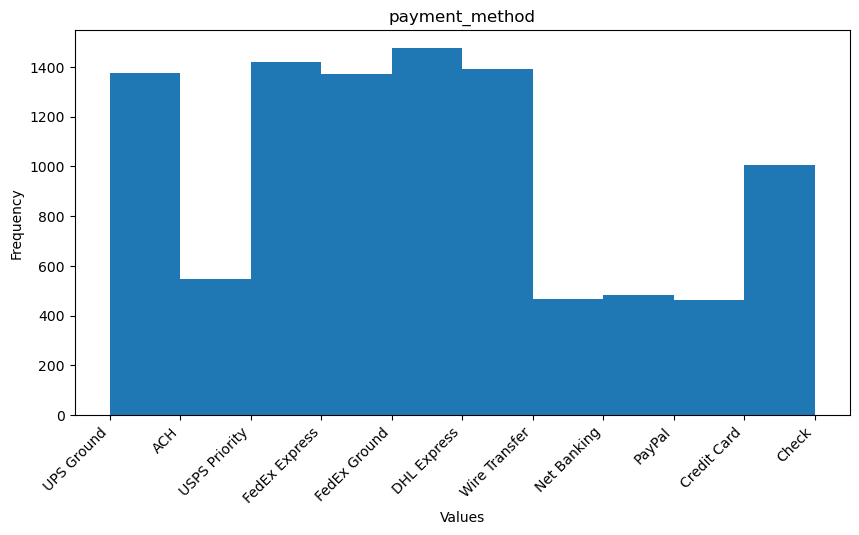

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(df2['payment_method'], bins=10)
plt.title('payment_method')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

In [23]:
date_format = "%m/%d/%Y"

df2['invoice_date'] = df2['invoice_date'].apply(lambda x: datetime.strptime(x, date_format) )
df2['due_date'] =  df2['due_date'].apply(lambda x: datetime.strptime(x, date_format) )

In [24]:
df2['time to pay'] = df2['due_date'] - df2['invoice_date']

In [25]:
df2['tax'] = df2['tax'].astype(float)
df2['grand_total'] = df2['grand_total'].astype(float)

In [26]:
df2['tax_rate'] = df2['tax']/df2['grand_total']

In [27]:
### FROM CATHERINE'S CODE

# Function to extract state from address (format: "Street, City, State ZIP, Country")
def extract_state(address):
    match = re.search(r'\b[A-Z]{2}\b', address)  # Match two-letter state codes
    return match.group(0) if match else None

# Apply state extraction
df2["state"] = df2["merchant_address"].apply(extract_state)

In [28]:
#Newly added by Frank

def feature_engineering(invoice_df, product_catalog):
    # Existing features
    invoice_df['total_line_items'] = invoice_df['line_details'].apply(len)
    invoice_df['total_quantity'] = invoice_df['line_details'].apply(
        lambda x: sum(int(line['line_qty']) for line in x)
    )
    
    # New: Duplicate product detection
    def count_duplicates(lines):
        models = [line.get('model', 'unknown') for line in lines]
        return sum(count > 1 for count in pd.Series(models).value_counts())
    
    invoice_df['duplicate_products_label'] = invoice_df['line_details'].apply(count_duplicates)
    
    # 2. Price deviation with model check
    def price_deviation(lines):
        deviations = []
        for line in lines:
            model = line.get("model")
            if not model:
                deviations.append(0)
                continue
            
            catalog_price = model_price_map.get(model, None)
            if not catalog_price:
                deviations.append(0)
                continue
            
            line_total = float(line["line_total"])
            expected_total = float(line["line_qty"]) * catalog_price
            deviations.append(abs(line_total - expected_total))
        
        return np.mean(deviations) if deviations else 0
    
    invoice_df['price_deviation_label'] = invoice_df['line_details'].apply(price_deviation)
    
    # New: Negative quantity flag
    invoice_df['negative_qty_label'] = invoice_df['line_details'].apply(
        lambda x: any(int(line['line_qty']) < 0 for line in x)
    ).astype(int)
    
    # New: Bulk purchase detection (top 1% of quantities)
    q_99 = invoice_df['total_quantity'].quantile(0.99)
    invoice_df['bulk_purchase_label'] = (invoice_df['total_quantity'] > q_99).astype(int)
    
    return invoice_df

In [29]:
df2 = feature_engineering(df2, product_catalog)

In [30]:
df2 = df2.drop(columns=['merchant_address', 'line_details'])

In [31]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,state_label,time to pay,tax_rate,state,total_line_items,total_quantity,duplicate_products_label,price_deviation_label,negative_qty_label,bulk_purchase_label
0,Barry,2025-02-07,Barry,Barry,2025-02-07,DUE ON RECEIPT,41329.39,2015.05,CUST-68053-2248,UPS Ground,...,0,0 days,0.048756,NM,4,26,1,0.0,0,0
1,Macdonald-Patterson Office Supplies International,2025-02-05,Macdonald-Patterson Office Supplies International,Macdonald-Patterson Office Supplies International,2025-04-06,NET 60 DAYS,3959.79,8.37,2503-6153,ACH,...,0,60 days,0.002114,OR,4,76,0,0.0,0,0
2,Sawyer Laboratory,2025-02-21,Sawyer Laboratory,Sawyer Laboratory,2025-04-22,NET 60 DAYS,44695.07,2026.75,2503-8546,USPS Priority,...,0,60 days,0.045346,NC,1,100,0,0.0,0,0
3,Stark-Church Enterprises,2025-02-28,Stark-Church Enterprises,Stark-Church Enterprises,2025-02-28,COD,196937.23,11146.33,P43535,FedEx Express,...,0,0 days,0.056598,IA,4,56,0,0.0,0,0
4,Bond Corp.,2024-12-22,Bond Corp.,Bond Corp.,2025-02-05,NET 45 DAYS,63744.05,4065.60,138132,FedEx Ground,...,0,45 days,0.063780,NV,5,157,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,GiveFact Office Supplies,2025-01-03,GiveFact Office Supplies,GiveFact Office Supplies,2025-01-03,DUE ON RECEIPT,2274.72,153.84,PO-63194,FedEx Express,...,0,0 days,0.067630,CA,3,56,0,0.0,0,0
9996,CrimeAcross,2025-03-06,CrimeAcross,CrimeAcross,2025-04-20,NET 45 DAYS,698.94,41.27,668521,Check,...,0,45 days,0.059047,AR,1,1,0,0.0,0,0
9997,Sanders,2025-01-30,Sanders,Sanders,2025-03-31,NET 60 DAYS,51.20,1.19,T54402,FedEx Ground,...,0,60 days,0.023242,KY,1,1,0,0.0,0,0
9998,Wall Telecommunications,2025-01-17,Wall Telecommunications,Wall Telecommunications,2025-02-16,NET 30 DAYS,297504.80,0.00,CUST-46916-8983,PayPal,...,0,30 days,0.000000,NH,6,117,1,0.0,0,0


In [258]:
df2.to_excel("output.xlsx", index=False) 

Tax rate should be 0 if it is anomaly?

In [32]:
# Encode categorical columns
categorical_cols = ['merchant', 'invoice_date', 'merchant_branch', 'merchant_chain', 'due_date', 'payment_terms', 'po_number', 'payment_method', 'currency', 'country', 'time to pay', 'due_date', 'state']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df2[col] = label_encoders[col].fit_transform(df2[col].astype(str))

In [33]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,state_label,time to pay,tax_rate,state,total_line_items,total_quantity,duplicate_products_label,price_deviation_label,negative_qty_label,bulk_purchase_label
0,317,287,317,317,184,2,41329.39,2015.05,6218,8,...,0,0,0.048756,37,4,26,1,0.0,0,0
1,2539,285,2539,2539,249,6,3959.79,8.37,1392,0,...,0,4,0.002114,42,4,76,0,0.0,0,0
2,3836,301,3836,3836,266,6,44695.07,2026.75,1783,9,...,0,4,0.045346,32,1,100,0,0.0,0,0
3,4163,308,4163,4163,207,1,196937.23,11146.33,7414,4,...,0,0,0.056598,15,4,56,0,0.0,0,0
4,440,240,440,440,182,5,63744.05,4065.60,138,5,...,0,3,0.063780,38,5,157,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1592,252,1592,1592,145,2,2274.72,153.84,8467,4,...,0,0,0.067630,5,3,56,0,0.0,0,0
9996,958,314,958,958,264,5,698.94,41.27,3620,1,...,0,3,0.059047,2,1,1,0,0.0,0,0
9997,3813,279,3813,3813,242,6,51.20,1.19,9352,5,...,0,4,0.023242,20,1,1,0,0.0,0,0
9998,4613,266,4613,4613,194,4,297504.80,0.00,5925,7,...,0,2,0.000000,35,6,117,1,0.0,0,0


In [34]:
df2.describe()

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,state_label,time to pay,tax_rate,state,total_line_items,total_quantity,duplicate_products_label,price_deviation_label,negative_qty_label,bulk_purchase_label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,2487.374000,263.749600,2487.374000,2487.374000,198.653000,3.71590,3.787102e+04,1581.273723,4877.035800,5.315100,...,0.141200,1.961300,0.041196,29.529100,3.444800,39.811300,0.053600,0.0,0.036000,0.009600
std,1455.133979,59.058885,1455.133979,1455.133979,60.403247,1.54707,7.148408e+04,3761.619352,2852.119194,2.850092,...,0.348245,1.200811,0.024778,17.204335,1.571496,46.740199,0.230938,0.0,0.186299,0.097513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.028000e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,-99.000000,0.000000,0.0,0.000000,0.000000
25%,1218.750000,241.000000,1218.750000,1218.750000,166.000000,3.00000,4.224035e+03,27.447500,2364.750000,3.000000,...,0.000000,2.000000,0.028183,14.000000,2.000000,7.000000,0.000000,0.0,0.000000,0.000000
50%,2481.500000,283.000000,2481.500000,2481.500000,210.000000,4.00000,1.263887e+04,357.335000,4862.500000,5.000000,...,0.000000,2.000000,0.051162,30.000000,3.000000,18.000000,0.000000,0.0,0.000000,0.000000
75%,3756.000000,306.000000,3756.000000,3756.000000,241.000000,5.00000,3.721017e+04,1385.905000,7356.250000,8.000000,...,0.000000,3.000000,0.057493,45.000000,4.000000,57.000000,0.000000,0.0,0.000000,0.000000
max,4994.000000,323.000000,4994.000000,4994.000000,360.000000,6.00000,1.063146e+06,82161.280000,9836.000000,10.000000,...,1.000000,4.000000,0.195223,58.000000,9.000000,373.000000,2.000000,0.0,1.000000,1.000000


# Feature Selection Models

In [35]:
df2['fraud_label'] = (df2['tax_label'] == 1) | (df2['state_label'] == 1)| (df2['duplicate_products_label'] == 1)| (df2['price_deviation_label'] == 1)|  (df2['negative_qty_label'] == 1) | (df2['bulk_purchase_label'] == 1)
df2['fraud_label'] = df2['fraud_label'].astype(int)

### Decision Tree

In [36]:
# Define features and target
X = df2.drop(columns=['fraud_label', 'tax_label', 'state_label','duplicate_products_label','price_deviation_label','negative_qty_label','bulk_purchase_label'])
y = df2['fraud_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start with small max depth to prevent overfit

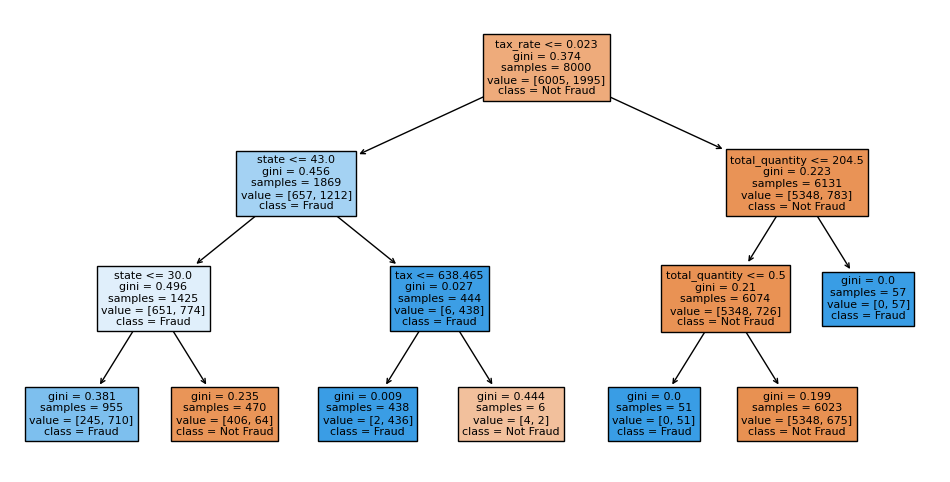

Model Accuracy: 0.87
Precision: 0.84
Recall: 0.61
F1-Score: 0.71
Confusion Matrix:
[[1418   61]
 [ 202  319]]


In [37]:
# train 
model_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
model_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(model_tree, feature_names=X.columns.tolist(), class_names=['Not Fraud', 'Fraud'], filled=True)
plt.show()

# predict
y_pred_tree = model_tree.predict(X_test)
#print(y_pred_tree)

# accuracy
accuracy = model_tree.score(X_test, y_test)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
conf_matrix = confusion_matrix(y_test, y_pred_tree)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: How many predicted fraud were actually fraud, TP / all positives

Recall: How many actual fraud were correctly detected,  TP / TP + FN

Confusion Matrix: Shows (going across) TP, FP, TN, FN

The tree chooses top 3 most influential features:
- tax_rate
- state
- total_quantity

compare with higher maxdepth

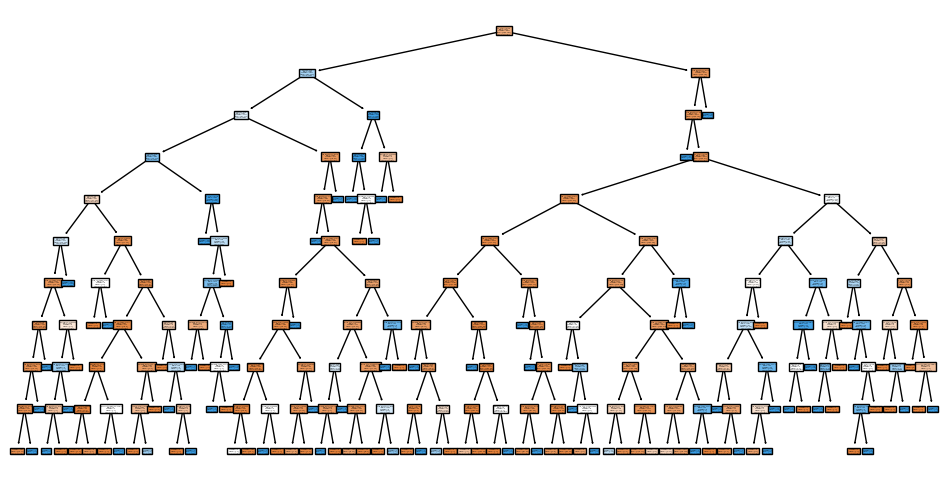

Model Accuracy: 0.89
Precision: 0.92
Recall: 0.63
F1-Score: 0.75
Confusion Matrix:
[[1452   27]
 [ 192  329]]


In [38]:
# train decision tree
model_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
model_tree.fit(X_train, y_train)

# plot
plt.figure(figsize=(12, 6))
plot_tree(model_tree, feature_names=X.columns.tolist(), class_names=['Not Fraud', 'Fraud'], filled=True)
plt.show()

# predict
y_pred_tree = model_tree.predict(X_test)

# accuracy
accuracy = model_tree.score(X_test, y_test)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
conf_matrix = confusion_matrix(y_test, y_pred_tree)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

same model accuracy

uses same features as above, added tax_rate as a feature. Only uses 4 features.


In [39]:
# Train Logistic Regression Model
model_logreg = LogisticRegression(max_iter=1000, random_state=42)
model_logreg.fit(X_train, y_train)

# Make predictions
y_pred = model_logreg.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.74
Precision: 0.53
Recall: 0.06
F1-Score: 0.11
Confusion Matrix:
[[1450   29]
 [ 488   33]]


In [34]:
'''
# use these two features
feature1 = 'tax_rate'
feature2 = 'grand_total'
Xplot = df2[[feature1, feature2]]
yplot = df2['label']

# normalize
scaler = StandardScaler()
Xplot_scaled = scaler.fit_transform(Xplot)

log_plot = LogisticRegression()
log_plot.fit(Xplot_scaled, yplot)

# Create a mesh grid for plotting decision boundary
x_min, x_max = Xplot_scaled[:, 0].min() - 1, Xplot_scaled[:, 0].max() + 1
y_min, y_max = Xplot_scaled[:, 1].min() - 1, Xplot_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on the grid
Z = log_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Scatter plot of actual data points
sns.scatterplot(x=Xplot_scaled[:, 0], y=Xplot_scaled[:, 1], hue=yplot, palette={0: 'blue', 1: 'red'})

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Logistic Regression Decision Boundary")
plt.legend(['Real', 'Fraud'])
plt.show()
'''

'\n# use these two features\nfeature1 = \'tax_rate\'\nfeature2 = \'grand_total\'\nXplot = df2[[feature1, feature2]]\nyplot = df2[\'label\']\n\n# normalize\nscaler = StandardScaler()\nXplot_scaled = scaler.fit_transform(Xplot)\n\nlog_plot = LogisticRegression()\nlog_plot.fit(Xplot_scaled, yplot)\n\n# Create a mesh grid for plotting decision boundary\nx_min, x_max = Xplot_scaled[:, 0].min() - 1, Xplot_scaled[:, 0].max() + 1\ny_min, y_max = Xplot_scaled[:, 1].min() - 1, Xplot_scaled[:, 1].max() + 1\nxx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),\n                     np.linspace(y_min, y_max, 200))\n\n# Predict on the grid\nZ = log_plot.predict(np.c_[xx.ravel(), yy.ravel()])\nZ = Z.reshape(xx.shape)\n\n# Plot decision boundary\nplt.figure(figsize=(8, 6))\nplt.contourf(xx, yy, Z, alpha=0.3, cmap=\'coolwarm\')\n\n# Scatter plot of actual data points\nsns.scatterplot(x=Xplot_scaled[:, 0], y=Xplot_scaled[:, 1], hue=yplot, palette={0: \'blue\', 1: \'red\'})\n\nplt.xlabel(feature1)\nplt.y